In [1]:
import math
import random
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from timeit import default_timer
from numpy import unique, ravel
from numpy import sqrt, dot, array, diagonal, mean, transpose, eye, diag, ones
from numpy import transpose, diag, dot
from numpy.linalg import svd, inv, qr, det
from sklearn.linear_model import LinearRegression

# For getting the top 20 pages and viewing them with print() statements

In [2]:
def topPages(__PRs, __U, __n = 10, TR=False):
    dd = {i: __PRs[i] for i in range(len(__PRs))}
    dd = {__U[page]: rank for page, rank in sorted(dd.items(), key=lambda kv: kv[1], reverse=True)}
    __pages = list(dd.keys())[:__n]
    dd= {page: dd[page] for page in __pages}
    if TR:
        return {"Link": list(dd.keys()), "Value": ravel(list(dd.values()))}
    return dd
    

def viewTopPages(__PRs, __U, __n = 10):
    if len(__PRs) == 1:
        __PRs = __PRs[0]
    __topPages = topPages(__PRs, __U, __n)
    for __page in __topPages:
        print(__page, __topPages[__page])

# Reading the data and deleting gibberish links

In [3]:
with open("U.txt") as f:
    U = f.readlines()
    Uraw = array(U)

with open("A.txt") as f2:
    A = f2.readlines()

U = [link[1:-2] for link in U]
A = [row[:-1] for row in A if row[-1] == "\n"]
A = [row.split(",") for row in A]
A = array([[int(entry) for entry in row] for row in A]).T

remove = [U[i] for i in (1, 45, 68, 149, 322, 381, 470)]
space = ", "
print(f"Removing links: {space.join(remove)}")

for link in remove:
    rem_ind = list(U).index(link)
    U = np.delete(U, rem_ind, 0)
    A = np.delete(A, rem_ind, 0)
    A = np.delete(A, rem_ind, 1)
print(f"Matrix A is of Dimensions {len(A)}x{len(A[0])}")

Removing links: http:/, http://b, http:, http://www, http://www., http:<a href=, http://edge
Matrix A is of Dimensions 493x493


# Old Iterative Page Rank Solution

This solution demonstrtes that the page rank problem can be solved iteratively.

In [4]:
n = len(A)
ninv = 1/n
TP = 0.85
TP_away = (1/n) * (1-TP)


class Page(object):
    def __init__(self, index):
        self.index = index
        self.in_links = []
        self.out_links = []
        self.rank = 0.1

class Network(object):
    def setupLinks(self):
        for page in self.pages:
            for i in range(len(self.A)):
                if self.A[page.index, i] == 1:
                    page.out_links.append(self.pages[i])
                if self.A[i, page.index] == 1:
                    page.in_links.append(self.pages[i])
    
    def __init__(self, adj_mtx):
        self.A = adj_mtx
        self.pages = [Page(index) for index in range(len(adj_mtx))]
        self.setupLinks()

    def surf(self, max_iter):
        for itr in range(max_iter):
            for page in self.pages:
                page.rank = TP * sum([p.rank / len(p.out_links) for p in page.in_links]) + TP_away

    def getPageRanks(self):
        norm = 1 / sum([page.rank for page in self.pages])
        return [norm * page.rank for page in self.pages]
        
network = Network(A.copy())

In [5]:
n_iterations = 50

start = default_timer()
network.surf(n_iterations)
stop = default_timer()

network_time = stop - start
print(f'PyIter/network took: {network_time}s for {n_iterations} iterations')

network_TP = topPages(network.getPageRanks(), U)  # dict
network_TP

PyIter/network took: 0.03187229996547103s for 50 iterations


{'http://ucdavis.edu/help/privacy-accessibility.html': 0.025697554706492265,
 'http://xmlns.com/foaf/0.1': 0.024467300234163766,
 'http://www.universityofcalifornia.edu': 0.02259976138991662,
 'http://browsehappy.com': 0.011522727615168819,
 'http://creativecommons.org/ns#': 0.011314904831628333,
 'http://disabilities.ucsd.edu': 0.010988129537824472,
 'http://ogp.me/ns#': 0.009023869372262369,
 'http://students.ucsd.edu': 0.008789076012161522,
 'http:\\/\\/schema.org': 0.008719538160017424,
 'http://drupal.org)': 0.00802961270927646}

# Linear Regression and SVD Dense Solvers

In [6]:
def convertToP(A):
    n = len(A)
    p = 0.85
    p1 = 0.15/n
    p2 = 1.0/n
    P = []
    for i in range(n):
        r = []
        ri = sum(A[i])
        if sum(A[i]) > 0:
            for j in range(n):
                r.append(p*(A[i,j]/ri) + p1)
        else:
            for j in range(n):
                r.append(p2)
        P.append(r)
    return array(P)

P = convertToP(A)

n = len(A)
p = 0.85
ri_not0 = (1-p)/float(n)

IP = np.eye(n) - P.T
np.sum(IP[:,0])
IP[0] = ones(n)
b = np.zeros(n).reshape(n,1)
b[0] = 1.0

In [7]:
print(f'Page Ranks for Network (50 iter): {network_time} seconds')

skLinReg = LinearRegression()
start = default_timer()
skLinReg.fit(IP,b)
stop = default_timer()
print(f'Page Ranks for Linear Regression: {stop - start} seconds')

start = default_timer()
u,d,v = svd(IP)
x = dot(v.T, inv(diag(d))).dot(u.T).dot(b)
stop = default_timer()
print(f'Page Ranks for SVD at: {stop - start} seconds')

print("")
print("For PyIter")
viewTopPages(network.getPageRanks(), U)
print("")
print("For Dense eigen-solution SVD")
viewTopPages(x, U)
print("")
print("For Dense Linear Regression")
viewTopPages(skLinReg.coef_, U)

Page Ranks for Network (50 iter): 0.03187229996547103 seconds
Page Ranks for Linear Regression: 0.08833429997321218 seconds
Page Ranks for SVD at: 0.12755400000605732 seconds

For PyIter
http://ucdavis.edu/help/privacy-accessibility.html 0.025697554706492265
http://xmlns.com/foaf/0.1 0.024467300234163766
http://www.universityofcalifornia.edu 0.02259976138991662
http://browsehappy.com 0.011522727615168819
http://creativecommons.org/ns# 0.011314904831628333
http://disabilities.ucsd.edu 0.010988129537824472
http://ogp.me/ns# 0.009023869372262369
http://students.ucsd.edu 0.008789076012161522
http:\/\/schema.org 0.008719538160017424
http://drupal.org) 0.00802961270927646

For Dense eigen-solution SVD
http://ucdavis.edu/help/privacy-accessibility.html [0.02571485]
http://xmlns.com/foaf/0.1 [0.02416929]
http://www.universityofcalifornia.edu [0.02261497]
http://browsehappy.com [0.01153048]
http://creativecommons.org/ns# [0.0111865]
http://disabilities.ucsd.edu [0.01089146]
http://ogp.me/ns# [0

In [8]:
network.getPageRanks()[:10]

[0.000879576900517748,
 0.002437562937439456,
 0.003100355927015785,
 0.0034354325247301096,
 0.0025403881730138252,
 0.005440479247305656,
 0.0025403881730138252,
 0.0025403881730138252,
 0.0021433082879197514,
 0.0021433082879197514]

In [9]:
x_TP = topPages(x, U, 5, TR=True)
x_TP

{'Link': ['http://ucdavis.edu/help/privacy-accessibility.html',
  'http://xmlns.com/foaf/0.1',
  'http://www.universityofcalifornia.edu',
  'http://browsehappy.com',
  'http://creativecommons.org/ns#'],
 'Value': array([0.02571485, 0.02416929, 0.02261497, 0.01153048, 0.0111865 ])}

In [10]:
df_x_TP = pd.DataFrame(x_TP)
df_x_TP

,Link,Value
0,http://ucdavis.edu/help/privacy-accessibility....,0.025715
1,http://xmlns.com/foaf/0.1,0.024169
2,http://www.universityofcalifornia.edu,0.022615
3,http://browsehappy.com,0.011530
4,http://creativecommons.org/ns#,0.011187


<AxesSubplot:xlabel='Value', ylabel='Link'>

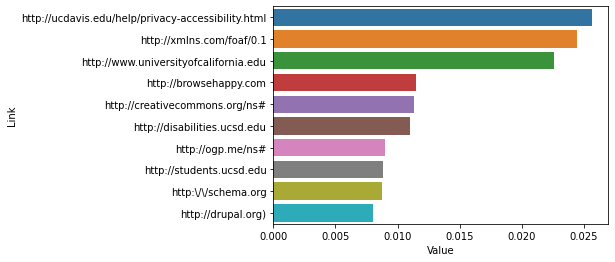

In [11]:
sns.barplot(x="Value", y="Link", data=pd.DataFrame(topPages(network.getPageRanks(), U, 10, TR=True)))

<AxesSubplot:xlabel='Value', ylabel='Link'>

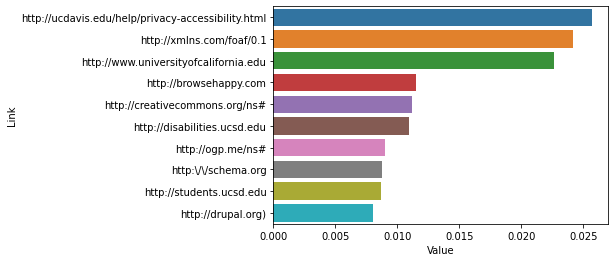

In [12]:
sns.barplot(x="Value", y="Link", data=pd.DataFrame(topPages(x, U, 10, TR=True)))

<AxesSubplot:xlabel='Value', ylabel='Link'>

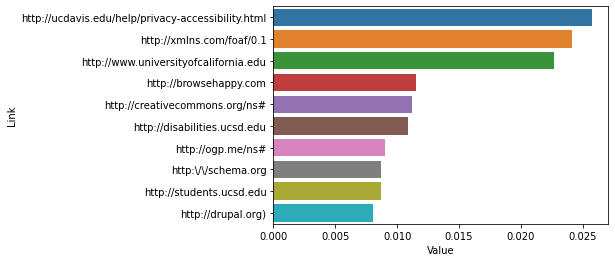

In [13]:
sns.barplot(x="Value", y="Link", data=pd.DataFrame(topPages(ravel(skLinReg.coef_), U, 10, TR=True)))

In [14]:
x_PowSol = np.zeros(493).reshape(493,1)
for i in range(len(x_PowSol)):
    x_PowSol[i] = 1/len(x_PowSol)

start = default_timer()
for itr in range(50):
    x_PowSol = dot(P.T, x_PowSol)
stop = default_timer()

print(f'Power Method: {stop - start} seconds')

Power Method: 0.006393300020135939 seconds


<AxesSubplot:xlabel='Value', ylabel='Link'>

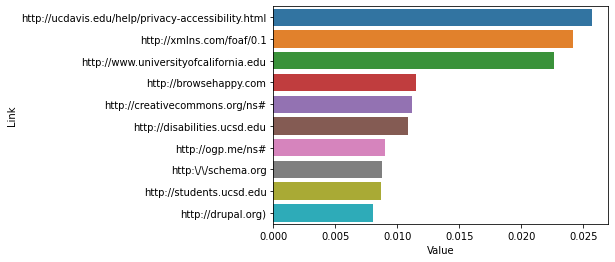

In [15]:
sns.barplot(x="Value", y="Link", data=pd.DataFrame(topPages(ravel(x_PowSol), U, 10, TR=True)))

In [16]:
names = ["PowerIter", "PyIter", "LR_Dense", "SVD_Dense"]
times = [0.00775069999508559,
0.02834740001708269,
0.08361859997967258,
0.20092139998450875]

<AxesSubplot:xlabel='Method', ylabel='Seconds'>

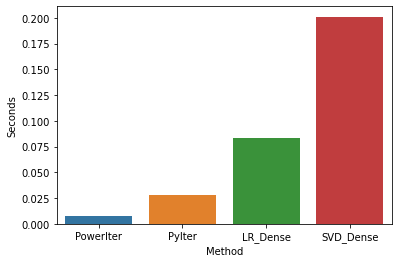

In [17]:
sns.barplot(x="Method", y="Seconds", data=pd.DataFrame({"Method":names, "Seconds":times}))

# Phi and e

In [18]:
def phi(n):
    if n == 1:
        return 1
    return 1/phi(n-1) + 1
    
print(phi(50))

1.618033988749895


In [19]:
def e(n, v=1, c=1):
    if n == 1:
        return 1
    return 1/v + e(n-1, v * (c+1), c+1)

print(e(50))

2.7182818284590455
